In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import itertools
from openpyxl import load_workbook
from tqdm.auto import tqdm
import models as md
import matplotlib.pyplot as plt
%matplotlib inline

### Exploration

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Simple model example

In [5]:
TT = md.TreeTester(data=data,target='DEATH_EVENT')
TT.evaluate()

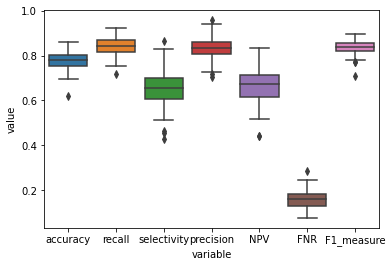

In [6]:
TT.plot_results()

In [7]:
# Train Size Test
# optimal train dataset size
# random extraction

train_size_array = np.arange(0.2,0.8,0.05)
accuracy_tst = []
recall_tst = []
selectivity_tst = []
precision_tst = []
NPV_tst = []
FNR_tst = []
F1_measure_tst = []
accuracy_tst_std = []
recall_tst_std = []
selectivity_tst_std = []
precision_tst_std = []
F1_measure_tst_std = []
NPV_tst_std = []
FNR_tst_std = []

for train_size in tqdm(train_size_array):
    TT = md.TreeTester(data=data,target='DEATH_EVENT',train_size=train_size,robustness_iterations=25)
    TT.evaluate()
    accuracy_tst.append(TT.evaluators.accuracy.mean())
    recall_tst.append(TT.evaluators.recall.mean())
    selectivity_tst.append(TT.evaluators.selectivity.mean())
    precision_tst.append(TT.evaluators.precision.mean())
    NPV_tst.append(TT.evaluators.NPV.mean())
    FNR_tst.append(TT.evaluators.FNR.mean())
    F1_measure_tst.append(TT.evaluators.F1_measure.mean())
    accuracy_tst_std.append(TT.evaluators.accuracy.std())
    recall_tst_std.append(TT.evaluators.recall.std())
    selectivity_tst_std.append(TT.evaluators.selectivity.std())
    precision_tst_std.append(TT.evaluators.precision.std())
    NPV_tst_std.append(TT.evaluators.NPV.std())
    FNR_tst_std.append(TT.evaluators.FNR.std())
    F1_measure_tst_std.append(TT.evaluators.F1_measure.std())

  0%|          | 0/13 [00:00<?, ?it/s]

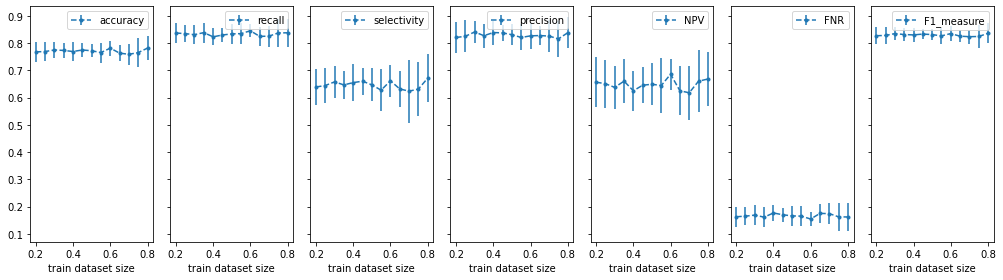

In [8]:
fig,axs = plt.subplots(1,7,figsize=(14,4),sharey=True)

axs[0].errorbar(train_size_array,accuracy_tst,yerr=accuracy_tst_std,fmt='.--',label='accuracy')
axs[1].errorbar(train_size_array,recall_tst,yerr=recall_tst_std,fmt='.--',label='recall')
axs[2].errorbar(train_size_array,selectivity_tst,yerr=selectivity_tst_std,fmt='.--',label='selectivity')
axs[3].errorbar(train_size_array,precision_tst,yerr=precision_tst_std,fmt='.--',label='precision')
axs[4].errorbar(train_size_array,NPV_tst,yerr=NPV_tst_std,fmt='.--',label='NPV')
axs[5].errorbar(train_size_array,FNR_tst,yerr=FNR_tst_std,fmt='.--',label='FNR')
axs[6].errorbar(train_size_array,F1_measure_tst,yerr=F1_measure_tst_std,fmt='.--',label='F1_measure')

for ax in axs:
    ax.set_xlabel('train dataset size')
    ax.legend()

fig.tight_layout()

In [9]:
# feature selection

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for column in tqdm(data.drop(['DEATH_EVENT','time'],axis=1).columns):
    TT = md.TreeTester(data=data.drop([column],axis=1),target='DEATH_EVENT')
    TT.evaluate()
    results[column] = TT.evaluators.mean()

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
pd.DataFrame.from_dict(results).round(3)

,all_set,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
accuracy,0.676,0.774,0.770,0.775,0.773,0.762,0.773,0.771,0.762,0.760,0.771,0.768
recall,0.766,0.833,0.833,0.843,0.837,0.833,0.838,0.832,0.825,0.819,0.836,0.831
selectivity,0.492,0.655,0.646,0.645,0.642,0.614,0.642,0.647,0.632,0.642,0.646,0.639
precision,0.759,0.833,0.828,0.827,0.830,0.818,0.829,0.833,0.828,0.830,0.828,0.829
NPV,0.500,0.654,0.650,0.665,0.650,0.637,0.653,0.641,0.622,0.620,0.655,0.639
FNR,0.234,0.167,0.167,0.157,0.163,0.167,0.162,0.168,0.175,0.181,0.164,0.169
F1_measure,0.761,0.832,0.829,0.833,0.832,0.825,0.832,0.831,0.825,0.823,0.830,0.828


### Running and saving

In [54]:
class Logger():
    def __init__(self,*args,**kwargs):
        # Set default parameters
        self.excel_filepath = 'results/df/test_log.xlsx'
        self.auto_train = False
        self.added_features = 0
        self.oversample = False
        self.forced_features = None
        self.train_size = 0.66
        self.robustness_iterations = 100
        # Update with provided parameters
        self.__dict__.update(kwargs)
    
    
    def update_log(self):
        line_info = {
            'auto_train': self.auto_train,
            'n_features': self.added_features,
            'oversample': self.oversample,
            'forced_features': self.forced_features,
            'train_size': self.train_size,
            'robustness_iterations': self.robustness_iterations
            }        
        try:
            book = load_workbook(self.excel_filepath)
            book = load_workbook(self.excel_filepath)
            writer = pd.ExcelWriter(self.excel_filepath, engine='openpyxl') 
            writer.book = book
            writer.book = book
            writer.sheets = {ws.title: ws for ws in book.worksheets}
            for sheetname in writer.sheets:
                pd.DataFrame([line_info]).to_excel(writer,sheet_name=sheetname,startrow=writer.sheets[sheetname].max_row,
                                                   index=True,header=False)

            writer.save()
        except: 
            print('No test log file - creating one')
            pd.DataFrame([line_info]).to_excel(self.excel_filepath)

In [56]:
logger = Logger(rorced_features = ['age','sex'])

In [58]:
logger.update_log()

In [ ]:
# feature selection

auto_train = False
added_features = 0
oversample = False
forced_features = None

line_info = {
    'auto_train': auto_train,
    'n_features': added_features,
    'oversample': oversample,
    'forced_features': forced_features
}

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [52]:

auto_train = False
added_features = 121
oversample = False
forced_features = ['age','sex']

line_info = {
    'auto_train': auto_train,
    'n_features': added_features,
    'oversample': oversample,
    'forced_features': forced_features
}

try:
    book = load_workbook('results/df/test_log.xlsx')
    book = load_workbook('results/df/test_log.xlsx')
    writer = pd.ExcelWriter('results/df/test_log.xlsx', engine='openpyxl') 
    writer.book = book
    writer.book = book
    writer.sheets = {ws.title: ws for ws in book.worksheets}
    for sheetname in writer.sheets:
        pd.DataFrame([line_info]).to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row,
                                           index = True,header= False)

    writer.save()
except: 
    print('No test log file - creating one')
    pd.DataFrame([line_info]).to_excel('results/df/test_log.xlsx')

In [35]:
# feature selection
import itertools

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

  0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

,"(diabetes, sex)","(anaemia, diabetes)","(sex, smoking)","(serum_creatinine, smoking)","(diabetes, ejection_fraction)","(anaemia, serum_creatinine)","(ejection_fraction, smoking)","(serum_creatinine, sex)","(high_blood_pressure, serum_creatinine)","(anaemia, ejection_fraction)",...,"(anaemia, platelets)","(high_blood_pressure, smoking)","(diabetes, platelets)","(high_blood_pressure, platelets)","(diabetes, high_blood_pressure)","(high_blood_pressure, sex)","(anaemia, high_blood_pressure)","(diabetes, smoking)","(anaemia, sex)","(anaemia, smoking)"
accuracy,0.683,0.680,0.686,0.734,0.706,0.708,0.705,0.704,0.695,0.697,...,0.568,0.671,0.563,0.559,0.676,0.680,0.675,0.682,0.677,0.680
recall,0.683,0.680,0.686,0.752,0.731,0.731,0.734,0.728,0.717,0.725,...,0.669,0.680,0.666,0.661,0.678,0.683,0.676,0.684,0.678,0.681
selectivity,NaN,NaN,0.735,0.667,0.614,0.612,0.611,0.598,0.597,0.597,...,0.306,0.293,0.280,0.267,0.205,0.191,0.176,0.126,0.067,0.000
precision,1.000,1.000,0.996,0.911,0.899,0.906,0.896,0.903,0.899,0.895,...,0.717,0.977,0.721,0.724,0.996,0.991,0.998,0.995,0.998,0.998
NPV,0.000,0.000,0.019,0.359,0.305,0.295,0.301,0.285,0.281,0.287,...,0.260,0.024,0.232,0.214,0.003,0.005,0.001,0.002,0.000,0.000
FNR,0.317,0.320,0.314,0.248,0.269,0.269,0.266,0.272,0.283,0.275,...,0.331,0.320,0.334,0.339,0.322,0.317,0.324,0.316,0.322,0.319
F1_measure,0.811,0.809,0.812,0.823,0.805,0.808,0.804,0.805,0.796,0.799,...,0.691,0.800,0.690,0.689,0.806,0.808,0.806,0.810,0.807,0.809


In [13]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 3))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

  0%|          | 0/165 [00:00<?, ?it/s]

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selectivity.append(TN/(TN+FP))
/home/demetrio/git_repo/machine_learning_playground/heart_failure/models.py:87: RuntimeWarning: invalid value encountered in long_scalars
  selec

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 3))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=True)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT',oversample=True)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT',oversample=True,
                       auto_train=True,added_features=1)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# feature selection
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=True,
                       auto_train=True,added_features=1)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results_df[list(results_df.columns)[10:40]]

In [ ]:
TT.plot_results()